In [39]:
import pandas as pd
import numpy as np
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import holidays

In [40]:
BASE_PATH = r"C:\Users\fdcontreras\OneDrive - Indra\Universidad\Despliegue de Soluciones Analíticas\Proyecto_Despliegue\Proyecto_Despliegue\data\01_raw"

def load_datasets():
    files = {
        'orders': 'olist_orders_dataset.csv',
        'order_items': 'olist_order_items_dataset.csv',
        'customers': 'olist_customers_dataset.csv',
        'products': 'olist_products_dataset.csv',
        'sellers': 'olist_sellers_dataset.csv',
        'order_payments': 'olist_order_payments_dataset.csv',
        'order_reviews': 'olist_order_reviews_dataset.csv',
        'geolocation': 'olist_geolocation_dataset.csv',
        'product_translation': 'product_category_name_translation.csv'
    }
    
    datasets = {}
    for name, filename in files.items():
        filepath = os.path.join(BASE_PATH, filename)
        datasets[name] = pd.read_csv(filepath)
    
    return datasets
data = load_datasets()

In [41]:

for name, df in data.items():
    print(f"{name}: {df.shape}")

orders: (99441, 8)
order_items: (112650, 7)
customers: (99441, 5)
products: (32951, 9)
sellers: (3095, 4)
order_payments: (103886, 5)
order_reviews: (99224, 7)
geolocation: (1000163, 5)
product_translation: (71, 2)


In [42]:

merged_df = data['orders'].merge(
    data['order_items'], 
    on='order_id', 
    how='left'
)

print(f"Después de order_items: {merged_df.shape}")

# Agregar información de productos
merged_df = merged_df.merge(
    data['products'], 
    on='product_id', 
    how='left'
)

print(f"Después de products: {merged_df.shape}")

# Agregar traducción de categorías
merged_df = merged_df.merge(
    data['product_translation'], 
    on='product_category_name', 
    how='left'
)

print(f"Después de product_translation: {merged_df.shape}")
# Agregar información de vendedores
merged_df = merged_df.merge(
    data['sellers'], 
    on='seller_id', 
    how='left'
)

print(f"Después de sellers: {merged_df.shape}")

# Agregar información de clientes
merged_df = merged_df.merge(
    data['customers'], 
    on='customer_id', 
    how='left'
)

print(f"Después de customers: {merged_df.shape}")

# Agregar pagos
merged_df = merged_df.merge(
    data['order_payments'], 
    on='order_id', 
    how='left'
)

print(f"Después de order_payments: {merged_df.shape}")

# Agregar reviews
merged_df = merged_df.merge(
    data['order_reviews'], 
    on='order_id', 
    how='left'
)

print(f"Después de order_reviews: {merged_df.shape}")

# Agregar geolocalización de clientes
customer_geo = data['geolocation'].drop_duplicates(subset=['geolocation_zip_code_prefix'])
customer_geo = customer_geo.rename(columns={
    'geolocation_zip_code_prefix': 'customer_zip_code_prefix',
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng',
    'geolocation_city': 'customer_geo_city',
    'geolocation_state': 'customer_geo_state'
})

merged_df = merged_df.merge(
    customer_geo, 
    on='customer_zip_code_prefix', 
    how='left'
)

print(f"Después de customer geolocation: {merged_df.shape}")

# Agregar geolocalización de vendedores
seller_geo = data['geolocation'].drop_duplicates(subset=['geolocation_zip_code_prefix'])
seller_geo = seller_geo.rename(columns={
    'geolocation_zip_code_prefix': 'seller_zip_code_prefix',
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng',
    'geolocation_city': 'seller_geo_city',
    'geolocation_state': 'seller_geo_state'
})

merged_df = merged_df.merge(
    seller_geo, 
    on='seller_zip_code_prefix', 
    how='left'
)

print(f"Dataset final: {merged_df.shape}")

# Verificar información del dataset final
print("Información del dataset consolidado:")
print(f"Filas: {merged_df.shape[0]:,}")
print(f"Columnas: {merged_df.shape[1]}")
print(f"Memoria: {merged_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Después de order_items: (113425, 14)
Después de products: (113425, 22)
Después de product_translation: (113425, 23)
Después de sellers: (113425, 26)
Después de customers: (113425, 30)
Después de order_payments: (118434, 34)
Después de order_reviews: (119143, 40)
Después de customer geolocation: (119143, 44)
Dataset final: (119143, 48)
Información del dataset consolidado:
Filas: 119,143
Columnas: 48
Memoria: 224.90 MB


In [ ]:

merged_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_lat,customer_lng,customer_geo_city,customer_geo_state,seller_lat,seller_lng,seller_geo_city,seller_geo_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350.0,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,-23.574809,-46.587471,sao paulo,SP,-23.680114,-46.452454,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350.0,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,-23.574809,-46.587471,sao paulo,SP,-23.680114,-46.452454,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350.0,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,-23.574809,-46.587471,sao paulo,SP,-23.680114,-46.452454,maua,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,31570.0,belo horizonte,SP,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,-12.169860,-44.988369,barreiras,BA,-19.810119,-43.984727,belo horizonte,MG
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 

In [44]:
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['order_date'] = merged_df['order_purchase_timestamp'].dt.date

In [45]:
category_days = (
    merged_df
      .groupby('product_category_name_english')['order_date']
      .nunique()
      .reset_index(name='unique_days')
      .sort_values('unique_days', ascending=False)
)

pd.set_option('display.max_rows',     None)
pd.set_option('display.max_columns',  None)
pd.set_option('display.width',        200)
pd.set_option('display.max_colwidth', None)

display(category_days)

,product_category_name_english,unique_days
39,furniture_decor,607
65,sports_leisure,603
43,health_beauty,602
7,bed_bath_table,598
15,computers_accessories,593
69,toys,590
68,telephony,588
49,housewares,587
42,garden_tools,585
20,cool_stuff,584


In [46]:
MIN_UNIQUE_DAYS = 45

valid_cats = (
    category_days[
        category_days['unique_days'] >= MIN_UNIQUE_DAYS
    ]['product_category_name_english']
    .tolist()
)

print(f"Categorías válidas (≥{MIN_UNIQUE_DAYS} días): {len(valid_cats)}\n", valid_cats)

Categorías válidas (≥45 días): 58
 ['furniture_decor', 'sports_leisure', 'health_beauty', 'bed_bath_table', 'computers_accessories', 'toys', 'telephony', 'housewares', 'garden_tools', 'cool_stuff', 'auto', 'perfumery', 'watches_gifts', 'baby', 'fashion_bags_accessories', 'pet_shop', 'stationery', 'electronics', 'luggage_accessories', 'office_furniture', 'consoles_games', 'small_appliances', 'musical_instruments', 'home_appliances', 'books_general_interest', 'construction_tools_construction', 'furniture_living_room', 'home_confort', 'home_construction', 'food', 'audio', 'market_place', 'drinks', 'air_conditioning', 'fashion_shoes', 'kitchen_dining_laundry_garden_furniture', 'home_appliances_2', 'fixed_telephony', 'books_technical', 'food_drink', 'industry_commerce_and_business', 'art', 'costruction_tools_garden', 'agro_industry_and_commerce', 'construction_tools_lights', 'construction_tools_safety', 'signaling_and_security', 'fashion_underwear_beach', 'christmas_supplies', 'computers', 

In [ ]:
daily = (
    merged_df
    .groupby(['product_category_name_english','order_date'])
    .size()
    .reset_index(name='units_sold')
)


daily.head()


,product_category_name_english,order_date,units_sold
0,agro_industry_and_commerce,2017-01-23,2
1,agro_industry_and_commerce,2017-01-31,1
2,agro_industry_and_commerce,2017-02-05,1
3,agro_industry_and_commerce,2017-02-08,1
4,agro_industry_and_commerce,2017-02-12,1


In [48]:
# Filtrar categorías con al menos 45 días de ventas
daily_filtered = daily[
    daily['product_category_name_english'].isin(valid_cats)
].copy()

print(f"daily_filtered shape: {daily_filtered.shape}")
daily_filtered['product_category_name_english'].nunique()

daily_filtered shape: (18180, 3)


58

In [49]:
pd.set_option('display.max_rows',   None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width',      200)

display(daily_filtered.head(20))

,product_category_name_english,order_date,units_sold
0,agro_industry_and_commerce,2017-01-23,2
1,agro_industry_and_commerce,2017-01-31,1
2,agro_industry_and_commerce,2017-02-05,1
3,agro_industry_and_commerce,2017-02-08,1
4,agro_industry_and_commerce,2017-02-12,1
5,agro_industry_and_commerce,2017-02-13,1
6,agro_industry_and_commerce,2017-02-16,1
7,agro_industry_and_commerce,2017-02-18,1
8,agro_industry_and_commerce,2017-02-21,3
9,agro_industry_and_commerce,2017-03-17,1


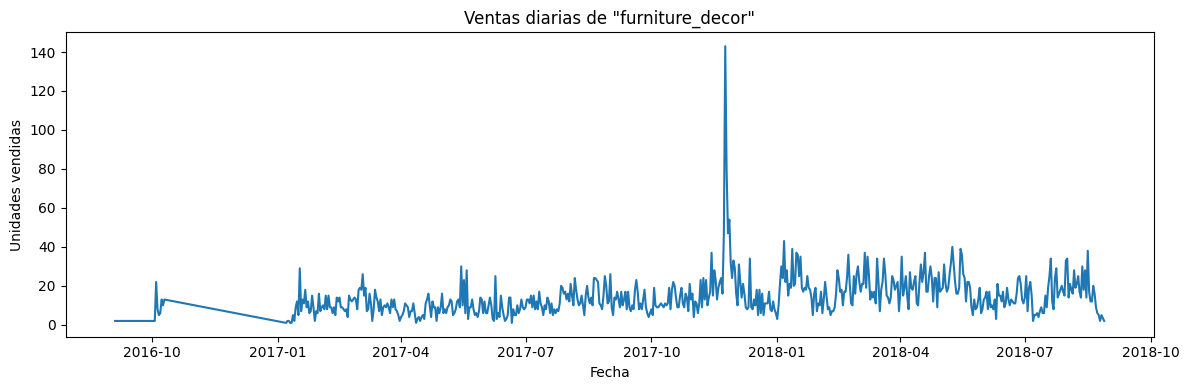

In [50]:
categoria = 'furniture_decor'  

df_plot = merged_df[merged_df['product_category_name_english'] == categoria].copy()

df_plot['order_date'] = pd.to_datetime(df_plot['order_date']).dt.date

ts = (
    df_plot
      .groupby('order_date')
      .size()
      .reset_index(name='ventas')
)

plt.figure(figsize=(12, 4))
plt.plot(ts['order_date'], ts['ventas'])
plt.title(f'Ventas diarias de "{categoria}"')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.tight_layout()
plt.show()

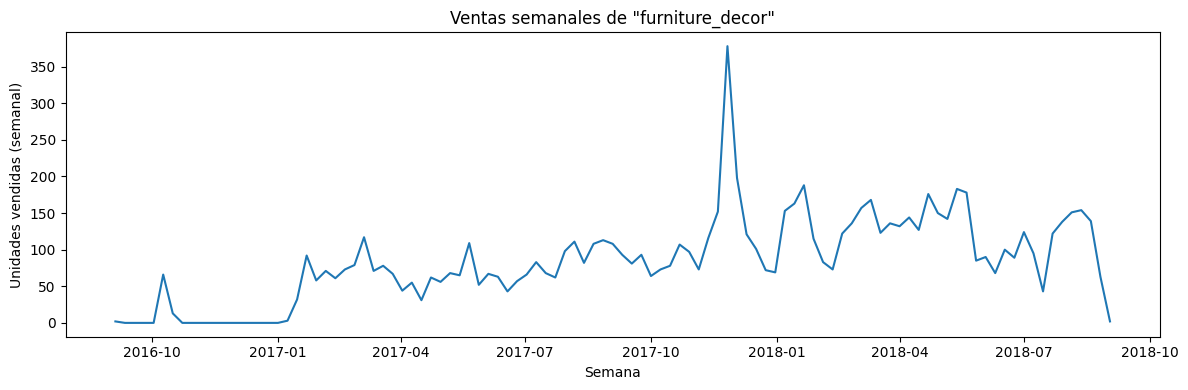

In [ ]:

categoria = 'furniture_decor' 


df_cat = merged_df[merged_df['product_category_name_english'] == categoria].copy()
df_cat['order_date'] = pd.to_datetime(df_cat['order_date'])


ventas_sem = df_cat.set_index('order_date').resample('W').size()


plt.figure(figsize=(12,4))
plt.plot(ventas_sem.index, ventas_sem.values)
plt.title(f'Ventas semanales de "{categoria}"')
plt.xlabel('Semana')
plt.ylabel('Unidades vendidas (semanal)')
plt.tight_layout()
plt.show()

In [52]:
TRAIN_DAYS     = 15
TS_SPLITS      = 5
OOB_CANDIDATES = [100, 200, 500]
RANDOM_STATE   = 42


years = sorted(daily['order_date'].apply(lambda d: d.year).unique())
br_hols = holidays.Brazil(years=years)

results = []
tscv    = TimeSeriesSplit(n_splits=TS_SPLITS)

In [53]:
for cat in valid_cats:
    df_cat = daily[
        daily['product_category_name_english'] == cat
    ].copy()
    df_cat['order_date'] = pd.to_datetime(df_cat['order_date'])
    df_cat.set_index('order_date', inplace=True)

    # 2.1) Feature Engineering diario
    df_cat['lag1']   = df_cat['units_sold'].shift(1)
    df_cat['roll7']  = df_cat['units_sold'].rolling(7).mean()
    idx = df_cat.index
    df_cat['dow_sin'] = np.sin(2*np.pi * idx.weekday / 7)
    df_cat['dow_cos'] = np.cos(2*np.pi * idx.weekday / 7)
    df_cat['mes_sin'] = np.sin(2*np.pi * idx.month   / 12)
    df_cat['mes_cos'] = np.cos(2*np.pi * idx.month   / 12)
    df_cat['festivo'] = idx.to_series().isin(br_hols).astype(int)
  
    bf_dates = []
    for y in idx.year.unique():
        nov = pd.date_range(f"{y}-11-01", f"{y}-11-30", freq="D")
        th  = nov[nov.weekday == 3]
        bf_dates.append((th[3] + pd.Timedelta(days=1)).date())
    df_cat['bf'] = df_cat.index.to_series().apply(lambda d: d.date() in bf_dates).astype(int)

  
    df_feat = df_cat.dropna()
    df_feat = df_feat.drop(columns=['product_category_name_english'])

    if len(df_feat) <= TRAIN_DAYS:
        continue



    X = df_feat.drop(columns=['units_sold'])
    y = df_feat['units_sold'].values
    X_train, X_test = X.iloc[:TRAIN_DAYS], X.iloc[TRAIN_DAYS:]
    y_train, y_test = y[:TRAIN_DAYS], y[TRAIN_DAYS:]
    if y_test.sum() == 0:
        continue


    best_oob, best_n = -np.inf, None
    for n in OOB_CANDIDATES:
        tmp = RandomForestRegressor(
            n_estimators = n,
            oob_score    = True,
            random_state = RANDOM_STATE,
            n_jobs       = -1
        )
        tmp.fit(X_train, y_train)
        if tmp.oob_score_ > best_oob:
            best_oob, best_n = tmp.oob_score_, n

    
    param_dist = {
        'n_estimators':    [max(5, best_n//2), best_n, best_n*2],
        'max_depth':       [None, 5, 10],
        'min_samples_leaf':[1, 2, 4],
        'max_features':    ['sqrt', 0.5]
    }
    search = RandomizedSearchCV(
        RandomForestRegressor(random_state=RANDOM_STATE, oob_score=True),
        param_distributions = param_dist,
        n_iter        = 20,
        cv            = tscv,
        scoring       = 'neg_mean_squared_error',
        n_jobs        = -1,
        random_state  = RANDOM_STATE
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

 
    preds = best_model.predict(X_test)
    mae   = mean_absolute_error(y_test, preds)
    rmse  = np.sqrt(mean_squared_error(y_test, preds))
    mape  = np.mean(np.abs((y_test - preds) / y_test)[y_test > 0]) * 100

    results.append({
        'category':       cat,
        'best_n_oob':     best_n,
        'init_oob_score': best_oob,
        'MAE':            mae,
        'RMSE':           rmse,
        'MAPE (%)':       mape,
        **search.best_params_
    })

res_rf = pd.DataFrame(results) \
            .sort_values('MAPE (%)') \
            .reset_index(drop=True)
pd.set_option('display.max_rows', None)
display(res_rf)

,category,best_n_oob,init_oob_score,MAE,RMSE,MAPE (%),n_estimators,min_samples_leaf,max_features,max_depth
0,dvds_blu_ray,100,1.000000,0.411765,1.028992,14.705882,100,1,sqrt,5.0
1,home_appliances_2,100,1.000000,0.472050,1.314043,16.725821,100,1,sqrt,5.0
2,cine_photo,500,-0.688199,0.396349,0.722477,19.676214,500,4,0.5,10.0
3,costruction_tools_tools,200,0.193632,0.419856,0.650260,23.726336,100,2,0.5,10.0
4,fashion_underwear_beach,200,-0.337711,0.439792,0.870518,24.490262,100,4,sqrt,NaN
5,books_technical,100,1.000000,0.655629,1.070372,25.607064,100,1,sqrt,5.0
6,books_imported,100,-0.505207,0.416333,0.607681,29.325000,100,1,sqrt,5.0
7,tablets_printing_image,500,-0.737589,0.416642,0.548254,30.317770,250,4,sqrt,NaN
8,industry_commerce_and_business,100,-0.634960,0.891663,1.401328,32.590034,100,4,0.5,10.0
9,furniture_bedroom,500,-0.856694,0.700430,2.019681,33.473208,500,1,sqrt,5.0
